In [1]:
# Tf version must be bigger than 2.3.0
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [3]:
audio_file_path = '17973-2-0-32.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [4]:
print(librosa_audio_data)

[ 0.05806023  0.04728271 -0.02169256 ... -0.00860656  0.03410248
  0.09018897]


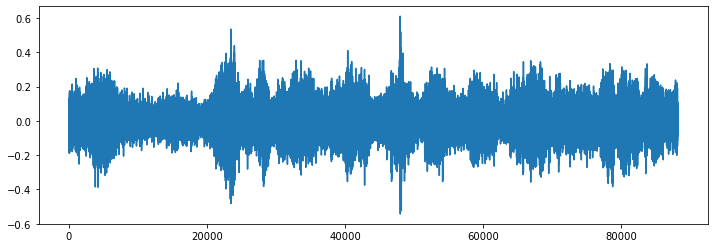

In [5]:
#Let's see the audio data
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

In [6]:
#let's read the sound
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [7]:
wave_audio

array([[2189, 3314],
       [1592, 2598],
       [ 848, 1712],
       ...,
       [1326, 2602],
       [1915, 3542],
       [2542, 4449]], dtype=int16)

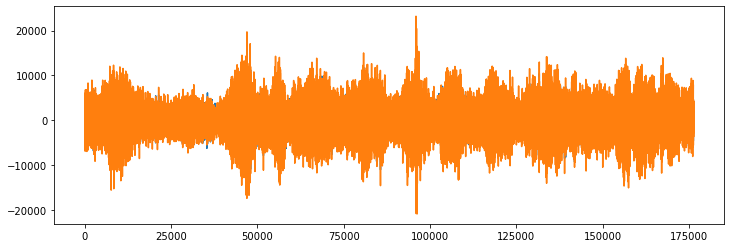

In [8]:
#Audio with 2 channels
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

In [9]:
mfcc_att = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc = 40) #n_mfcc: Number of MFCCs to return(default=20)
print(mfcc_att.shape)

(40, 173)


In [10]:
mfcc_att

array([[-167.09666  , -152.27574  , -172.7387   , ..., -192.53252  ,
        -179.42377  , -179.9042   ],
       [  77.15352  ,   94.49202  ,  109.3145   , ...,  107.66588  ,
          87.717316 ,   67.726715 ],
       [-108.97769  , -119.88193  , -128.7536   , ..., -112.772415 ,
         -98.41925  ,  -86.16422  ],
       ...,
       [  -9.484234 ,   -8.975718 ,  -14.132221 , ...,   -6.5950375,
          -1.9226944,   -5.5306387],
       [   4.7791624,    3.693905 ,    5.1923394, ...,   -4.643524 ,
         -12.0100975,  -17.334637 ],
       [   5.1541758,    7.4267035,    7.0431576, ...,   -2.69385  ,
          -6.3918595,   -7.203297 ]], dtype=float32)

In [11]:
audio_dataset_path = 'UrbanSound8K/audio/'
mdata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
mdata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [12]:
def features_find(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfcc_att = librosa .feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfcc_att_scaled_features = np.mean(mfcc_att.T, axis=0)
    return mfcc_att_scaled_features

In [13]:
finded_features = []
for index_num, row in tqdm(mdata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row['fold']) + '/', str(row['slice_file_name']))
    final_class_labels = row['class']
    data = features_find(file_name)
    finded_features.append([data, final_class_labels])

3553it [02:51, 20.16it/s]C:\Users\Public\anaconda\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8324it [06:33, 30.49it/s]C:\Users\Public\anaconda\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Public\anaconda\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [06:50, 21.27it/s]


In [14]:
finded_features_df = pd.DataFrame(finded_features, columns = ['feature', 'class'])
finded_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [15]:
X = np.array(finded_features_df['feature'].tolist())
y =  np.array(finded_features_df['class'].tolist())

In [16]:
X.shape

(8732, 40)

In [17]:
X

array([[-2.1735526e+02,  7.0223381e+01, -1.3038527e+02, ...,
        -1.6930529e+00, -6.1698371e-01,  3.8600543e-01],
       [-4.2409818e+02,  1.0934077e+02, -5.2919525e+01, ...,
         5.3489321e-01, -5.4468727e-01,  4.4632098e-01],
       [-4.5879114e+02,  1.2138419e+02, -4.6520657e+01, ...,
         2.0768483e+00,  1.6962963e+00, -9.6140963e-01],
       ...,
       [-3.0388824e+02,  1.1135945e+02, -4.5941563e+01, ...,
        -3.0292380e+00,  2.7170298e+00,  7.6197419e+00],
       [-3.4411008e+02,  1.2545021e+02, -5.4903442e+01, ...,
        -7.9082441e+00, -1.6414586e+00,  5.6668439e+00],
       [-3.1560281e+02,  9.4854805e+01, -3.7222340e+01, ...,
         6.1386460e-01, -1.1449189e+01, -6.0105853e+00]], dtype=float32)

In [18]:
y.shape

(8732,)

In [19]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [20]:
y[0]

'dog_bark'

In [21]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [23]:
X_train

array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665260e+00, -1.36902368e+00,  2.75575495e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273319e+00, ...,
        -3.25305033e+00, -5.27745247e+00, -1.55697143e+00],
       [-4.98715439e+01,  2.65352994e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920441e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939739e+00, ...,
         7.42641389e-01,  7.33490825e-01,  7.11009085e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155220e+01, ...,
         1.46811950e+00, -2.00917006e+00, -8.82181883e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066067e+00, ...,
        -5.38886738e+00, -3.37136054e+00, -1.56651151e+00]], dtype=float32)

In [24]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
X_train.shape

(6985, 40)

In [26]:
X_test.shape

(1747, 40)

In [27]:
y_train.shape

(6985, 10)

In [28]:
y_test.shape

(1747, 10)

## Building the CNN Model

In [29]:
num_labels = 10

In [30]:
model = Sequential()
#First hidden layer
model.add(Dense(125, input_shape = (40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Second hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Third hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 125)               5125      
_________________________________________________________________
activation (Activation)      (None, 125)               0         
_________________________________________________________________
dropout (Dropout)            (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               31500     
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 125)               3

In [35]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer ='adam')

In [37]:
ecount = 750
num_batch_size = 32
model.fit(X_train, y_train, batch_size = num_batch_size, epochs = ecount, validation_data = (X_test, y_test), verbose = 1)

Epoch 1/750
219/219 [==============================] - 0s 2ms/step - loss: 1.4302 - accuracy: 0.5094 - val_loss: 1.2445 - val_accuracy: 0.6096
Epoch 2/750
219/219 [==============================] - 0s 2ms/step - loss: 1.3773 - accuracy: 0.5297 - val_loss: 1.1788 - val_accuracy: 0.6319
Epoch 3/750
219/219 [==============================] - 0s 2ms/step - loss: 1.3486 - accuracy: 0.5360 - val_loss: 1.1494 - val_accuracy: 0.6274
Epoch 4/750
219/219 [==============================] - 0s 2ms/step - loss: 1.3167 - accuracy: 0.5509 - val_loss: 1.0925 - val_accuracy: 0.6560
Epoch 5/750
219/219 [==============================] - 0s 2ms/step - loss: 1.2967 - accuracy: 0.5601 - val_loss: 1.1022 - val_accuracy: 0.6394
Epoch 6/750
219/219 [==============================] - 0s 2ms/step - loss: 1.2843 - accuracy: 0.5632 - val_loss: 1.1073 - val_accuracy: 0.6525
Epoch 7/750
219/219 [==============================] - 0s 2ms/step - loss: 1.2723 - accuracy: 0.5692 - val_loss: 1.0724 - val_accuracy: 0.6480

Epoch 58/750
219/219 [==============================] - 1s 2ms/step - loss: 0.9020 - accuracy: 0.7061 - val_loss: 0.7351 - val_accuracy: 0.7665
Epoch 59/750
219/219 [==============================] - 1s 3ms/step - loss: 0.8986 - accuracy: 0.7008 - val_loss: 0.7115 - val_accuracy: 0.7739
Epoch 60/750
219/219 [==============================] - 0s 2ms/step - loss: 0.9067 - accuracy: 0.7014 - val_loss: 0.7275 - val_accuracy: 0.7705
Epoch 61/750
219/219 [==============================] - 1s 3ms/step - loss: 0.8906 - accuracy: 0.7049 - val_loss: 0.7049 - val_accuracy: 0.7693
Epoch 62/750
219/219 [==============================] - 1s 2ms/step - loss: 0.8735 - accuracy: 0.7067 - val_loss: 0.6993 - val_accuracy: 0.7853
Epoch 63/750
219/219 [==============================] - 1s 3ms/step - loss: 0.8855 - accuracy: 0.7098 - val_loss: 0.7019 - val_accuracy: 0.7716
Epoch 64/750
219/219 [==============================] - 1s 3ms/step - loss: 0.8972 - accuracy: 0.7095 - val_loss: 0.6964 - val_accuracy:

Epoch 115/750
219/219 [==============================] - 0s 2ms/step - loss: 0.8255 - accuracy: 0.7301 - val_loss: 0.6229 - val_accuracy: 0.8042
Epoch 116/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7968 - accuracy: 0.7347 - val_loss: 0.6312 - val_accuracy: 0.8071
Epoch 117/750
219/219 [==============================] - 1s 2ms/step - loss: 0.8042 - accuracy: 0.7416 - val_loss: 0.6250 - val_accuracy: 0.8060
Epoch 118/750
219/219 [==============================] - 1s 2ms/step - loss: 0.8101 - accuracy: 0.7361 - val_loss: 0.6379 - val_accuracy: 0.7997
Epoch 119/750
219/219 [==============================] - 1s 3ms/step - loss: 0.8071 - accuracy: 0.7291 - val_loss: 0.6472 - val_accuracy: 0.7911
Epoch 120/750
219/219 [==============================] - 1s 3ms/step - loss: 0.8162 - accuracy: 0.7339 - val_loss: 0.6362 - val_accuracy: 0.7905
Epoch 121/750
219/219 [==============================] - 0s 2ms/step - loss: 0.8147 - accuracy: 0.7343 - val_loss: 0.6284 - val_ac

219/219 [==============================] - 0s 2ms/step - loss: 0.7551 - accuracy: 0.7499 - val_loss: 0.5908 - val_accuracy: 0.8060
Epoch 172/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7575 - accuracy: 0.7466 - val_loss: 0.5840 - val_accuracy: 0.8122
Epoch 173/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7530 - accuracy: 0.7512 - val_loss: 0.5845 - val_accuracy: 0.8128
Epoch 174/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7505 - accuracy: 0.7558 - val_loss: 0.5849 - val_accuracy: 0.8174
Epoch 175/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7646 - accuracy: 0.7490 - val_loss: 0.5825 - val_accuracy: 0.8111
Epoch 176/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7583 - accuracy: 0.7500 - val_loss: 0.6007 - val_accuracy: 0.8060
Epoch 177/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7474 - accuracy: 0.7523 - val_loss: 0.5885 - val_accuracy: 0.8100

219/219 [==============================] - 1s 2ms/step - loss: 0.7369 - accuracy: 0.7583 - val_loss: 0.5719 - val_accuracy: 0.8237
Epoch 228/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7442 - accuracy: 0.7513 - val_loss: 0.5648 - val_accuracy: 0.8214
Epoch 229/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7337 - accuracy: 0.7571 - val_loss: 0.5730 - val_accuracy: 0.8163
Epoch 230/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7108 - accuracy: 0.7692 - val_loss: 0.5609 - val_accuracy: 0.8185
Epoch 231/750
219/219 [==============================] - 1s 3ms/step - loss: 0.7215 - accuracy: 0.7602 - val_loss: 0.5680 - val_accuracy: 0.8157
Epoch 232/750
219/219 [==============================] - 1s 3ms/step - loss: 0.7218 - accuracy: 0.7674 - val_loss: 0.5673 - val_accuracy: 0.8208
Epoch 233/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7330 - accuracy: 0.7532 - val_loss: 0.5712 - val_accuracy: 0.8220

219/219 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.7664 - val_loss: 0.5557 - val_accuracy: 0.8266
Epoch 284/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7181 - accuracy: 0.7626 - val_loss: 0.5410 - val_accuracy: 0.8220
Epoch 285/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.7671 - val_loss: 0.5364 - val_accuracy: 0.8300
Epoch 286/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7203 - accuracy: 0.7685 - val_loss: 0.5612 - val_accuracy: 0.8288
Epoch 287/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7231 - accuracy: 0.7629 - val_loss: 0.5427 - val_accuracy: 0.8248
Epoch 288/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7256 - accuracy: 0.7634 - val_loss: 0.5358 - val_accuracy: 0.8311
Epoch 289/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7202 - accuracy: 0.7682 - val_loss: 0.5462 - val_accuracy: 0.8254

219/219 [==============================] - 1s 2ms/step - loss: 0.7153 - accuracy: 0.7641 - val_loss: 0.5469 - val_accuracy: 0.8197
Epoch 340/750
219/219 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.7728 - val_loss: 0.5496 - val_accuracy: 0.8220
Epoch 341/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.7648 - val_loss: 0.5155 - val_accuracy: 0.8340
Epoch 342/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.7721 - val_loss: 0.5369 - val_accuracy: 0.8374
Epoch 343/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7141 - accuracy: 0.7675 - val_loss: 0.5232 - val_accuracy: 0.8414
Epoch 344/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7154 - accuracy: 0.7659 - val_loss: 0.5544 - val_accuracy: 0.8185
Epoch 345/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.7788 - val_loss: 0.5230 - val_accuracy: 0.8329

219/219 [==============================] - 0s 2ms/step - loss: 0.6663 - accuracy: 0.7817 - val_loss: 0.5191 - val_accuracy: 0.8414
Epoch 396/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.7810 - val_loss: 0.5240 - val_accuracy: 0.8392
Epoch 397/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6735 - accuracy: 0.7840 - val_loss: 0.5383 - val_accuracy: 0.8300
Epoch 398/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6796 - accuracy: 0.7770 - val_loss: 0.5495 - val_accuracy: 0.8220
Epoch 399/750
219/219 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.7685 - val_loss: 0.5328 - val_accuracy: 0.8306
Epoch 400/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.7805 - val_loss: 0.5233 - val_accuracy: 0.8288
Epoch 401/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.7791 - val_loss: 0.5325 - val_accuracy: 0.8323

219/219 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.7814 - val_loss: 0.5391 - val_accuracy: 0.8226
Epoch 452/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.7834 - val_loss: 0.5243 - val_accuracy: 0.8323
Epoch 453/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6832 - accuracy: 0.7858 - val_loss: 0.5127 - val_accuracy: 0.8306
Epoch 454/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.7797 - val_loss: 0.5124 - val_accuracy: 0.8363
Epoch 455/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.7780 - val_loss: 0.5247 - val_accuracy: 0.8288
Epoch 456/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6813 - accuracy: 0.7771 - val_loss: 0.5199 - val_accuracy: 0.8374
Epoch 457/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.7787 - val_loss: 0.5420 - val_accuracy: 0.8220

219/219 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.7847 - val_loss: 0.5239 - val_accuracy: 0.8340
Epoch 508/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6755 - accuracy: 0.7843 - val_loss: 0.5308 - val_accuracy: 0.8329
Epoch 509/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.7854 - val_loss: 0.5150 - val_accuracy: 0.8334
Epoch 510/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6472 - accuracy: 0.7914 - val_loss: 0.5353 - val_accuracy: 0.8317
Epoch 511/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6728 - accuracy: 0.7810 - val_loss: 0.5283 - val_accuracy: 0.8340
Epoch 512/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.7788 - val_loss: 0.5287 - val_accuracy: 0.8369
Epoch 513/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.7840 - val_loss: 0.5266 - val_accuracy: 0.8306

219/219 [==============================] - 0s 2ms/step - loss: 0.6469 - accuracy: 0.7890 - val_loss: 0.5460 - val_accuracy: 0.8191
Epoch 564/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.7791 - val_loss: 0.5274 - val_accuracy: 0.8237
Epoch 565/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.7963 - val_loss: 0.5029 - val_accuracy: 0.8334
Epoch 566/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6514 - accuracy: 0.7890 - val_loss: 0.5191 - val_accuracy: 0.8340
Epoch 567/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.7863 - val_loss: 0.5088 - val_accuracy: 0.8288
Epoch 568/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.7827 - val_loss: 0.5103 - val_accuracy: 0.8369
Epoch 569/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6550 - accuracy: 0.7887 - val_loss: 0.5241 - val_accuracy: 0.8203

219/219 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.7810 - val_loss: 0.5412 - val_accuracy: 0.8260
Epoch 620/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.7906 - val_loss: 0.5311 - val_accuracy: 0.8414
Epoch 621/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.7913 - val_loss: 0.5398 - val_accuracy: 0.8323
Epoch 622/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.7880 - val_loss: 0.5318 - val_accuracy: 0.8248
Epoch 623/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6426 - accuracy: 0.7931 - val_loss: 0.5192 - val_accuracy: 0.8357
Epoch 624/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6450 - accuracy: 0.7911 - val_loss: 0.5326 - val_accuracy: 0.8334
Epoch 625/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6435 - accuracy: 0.7940 - val_loss: 0.5039 - val_accuracy: 0.8380

219/219 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.7950 - val_loss: 0.5123 - val_accuracy: 0.8357
Epoch 676/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.7927 - val_loss: 0.5021 - val_accuracy: 0.8489
Epoch 677/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6412 - accuracy: 0.7903 - val_loss: 0.5141 - val_accuracy: 0.8374
Epoch 678/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6281 - accuracy: 0.8004 - val_loss: 0.4983 - val_accuracy: 0.8489
Epoch 679/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.7850 - val_loss: 0.5295 - val_accuracy: 0.8323
Epoch 680/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.7906 - val_loss: 0.5187 - val_accuracy: 0.8323
Epoch 681/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6571 - accuracy: 0.7802 - val_loss: 0.5138 - val_accuracy: 0.8334

219/219 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.7904 - val_loss: 0.5235 - val_accuracy: 0.8277
Epoch 732/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.7885 - val_loss: 0.5238 - val_accuracy: 0.8374
Epoch 733/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6437 - accuracy: 0.7937 - val_loss: 0.5296 - val_accuracy: 0.8248
Epoch 734/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.7857 - val_loss: 0.5227 - val_accuracy: 0.8386
Epoch 735/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6606 - accuracy: 0.7900 - val_loss: 0.5266 - val_accuracy: 0.8346
Epoch 736/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.7877 - val_loss: 0.5215 - val_accuracy: 0.8351
Epoch 737/750
219/219 [==============================] - 0s 2ms/step - loss: 0.6286 - accuracy: 0.7980 - val_loss: 0.5164 - val_accuracy: 0.8409

In [38]:
validation_test_set_accuracy = model.evaluate(X_test, y_test, verbose = 0)
print(validation_test_set_accuracy[1])

0.8362907767295837


In [39]:
X_test[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.33935   ,
        -14.88148   ,  -19.12843   ,   -0.581684  ,  -16.130579  ,
        -21.339075  ,    7.673634  ,  -29.16449   ,  -18.950253  ,
         -2.9579995 ,   -8.162329  ,  -15.153101  ,   -6.604805  ,
         -7.5685983 ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340122 ,  -19.228804  ,   -4.630231  ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.5334608 ,  -23.843391  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.58320105,
         -1.2624055 ,   17.700016  ,   13.847463  ,   -5.1862826 ],
      dtype=float32)

In [50]:
model.predict_step(X_test)

<tf.Tensor: shape=(1747, 10), dtype=float32, numpy=
array([[1.52652346e-09, 1.99030433e-06, 7.09070207e-07, ...,
        2.53707125e-11, 8.03163800e-07, 7.12504261e-05],
       [2.43775314e-04, 1.41504053e-02, 3.35231833e-02, ...,
        9.31079630e-05, 2.78526964e-03, 1.82021603e-01],
       [1.07180385e-04, 1.37095489e-02, 2.46760692e-03, ...,
        1.78817008e-02, 5.45713934e-04, 3.56339291e-02],
       ...,
       [4.92718566e-31, 1.00000000e+00, 2.55605117e-18, ...,
        4.61745833e-26, 4.54478241e-17, 1.39201997e-10],
       [3.60090435e-02, 5.55430725e-03, 4.87229288e-01, ...,
        8.80582444e-03, 1.34671535e-02, 3.16914678e-01],
       [3.92420143e-02, 4.60274778e-02, 1.01574942e-01, ...,
        5.51176816e-03, 2.63304077e-02, 3.54322135e-01]], dtype=float32)>

## Predict Time

In [102]:
filename = '17973-2-0-32.wav'
sound_signal, sample_rate = librosa.load(filename, res_type = 'kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc = 40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)

In [103]:
print(mfccs_scaled_features)

[-162.07869     110.56539    -134.4945       44.469692    -32.97903
   22.780281     -6.7410436    11.667117      8.739887     -0.90248823
   -5.6070814    -3.8684795     5.967379     -5.570515      5.0175457
    8.397354      8.8369055    -7.259947     -4.253708     -1.1715367
    4.7644305    -6.187425     -6.1415887    -3.029989     -1.1254538
    7.432242     -2.6664758    -2.1235545     3.8758376     3.2612932
   -3.8346853    -1.1993946    -1.5478235     1.6386476    -2.4035416
   -0.87558603    0.17004737   -2.7598627    -1.511601     -0.6348454 ]


In [104]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

In [105]:
mfccs_scaled_features.shape

(1, 40)

In [106]:
print(mfccs_scaled_features)

[[-162.07869     110.56539    -134.4945       44.469692    -32.97903
    22.780281     -6.7410436    11.667117      8.739887     -0.90248823
    -5.6070814    -3.8684795     5.967379     -5.570515      5.0175457
     8.397354      8.8369055    -7.259947     -4.253708     -1.1715367
     4.7644305    -6.187425     -6.1415887    -3.029989     -1.1254538
     7.432242     -2.6664758    -2.1235545     3.8758376     3.2612932
    -3.8346853    -1.1993946    -1.5478235     1.6386476    -2.4035416
    -0.87558603    0.17004737   -2.7598627    -1.511601     -0.6348454 ]]


In [107]:
print(mfccs_scaled_features.shape)

(1, 40)


In [108]:
result_array = model.predict(mfccs_scaled_features)

In [109]:
result_array

array([[2.7503756e-08, 7.8701210e-05, 9.6139890e-01, 2.4591856e-02,
        3.7836882e-05, 4.6023993e-06, 1.3580756e-02, 2.9729799e-12,
        2.8325990e-04, 2.4083911e-05]], dtype=float32)

In [110]:
result_classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling, engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'] 
result = np.argmax(result_array[0])
print(result_classes[result])

children_playing
